In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from itertools import product
import pandas as pd
import h5py

/usr/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Create fake population

With:

- hierarchy:
    - 5 levels:
    - 3 levels are administrative: 10000 people per level 0, 2500 per level 1, 625 per level 2
    - last two levels are the community and household: ~180 per level 3 and then level 4 are clusters of ~25 households;

- households:
    - 1/size probability in size;
    - 2 person households are 70% adult couples and 30% single parent with children < 18;
    - discard by now single parent with multiple children;
    - Adults age flat 18 < age < 100;
    - children flat 0, 18;
    - 50/50 sex;
    - progressive id of household and agents;
    - adults 80% with workplace 20% unemplyed;
    - children 100% to school;
    - adults education: 20% = 0 (elementary); 50% = 1 (secondary); 30% = 2 (university);
    - adults income: normal distribution avg 1000 std 200;
    
- workplaces/schools:
    - size sampled from normal avg 60 std 10;
    - create as many as necessary and assign them to 3-rd level;
    - children goes to infantry (0 <= age < 6, code 0), elementary (6 <= age < 11, code 1) or secondary  (11 <= age < 19, code 2) schools;

- demography
    - we use the data of the natality/mortality rates in ...

In [3]:
#################
# Configuration #
#################

numberOfLevels = 5
administrativeLevel = 3
nCodesPerLevel = 4

sizeLevel = [5000, 1250, 320, 80, 20]

In [29]:
levelCodes = [range(nCodesPerLevel)]*numberOfLevels

def generateAdminCodes(args):
    return list(product(*args))

administrativeCodes = generateAdminCodes(levelCodes[:administrativeLevel])


### The fake table of household size CDF

In this example we use a $P(s) \propto 1/s$ household size distribution (with $s\in [1,8]$) for each geographical area.

In [38]:
maxHouseholdSize = 8

singleCDF = np.cumsum(1./np.arange(1, 1+maxHouseholdSize))
singleCDF /= singleCDF[-1]
hhsizeCDF = {code: singleCDF for code in administrativeCodes}

# Function that returns the householdSize for a given geocode...
sampleHouseholdSize = lambda geocode: np.argmax(np.random.rand() < hhsizeCDF[geocode]) + 1

In [4]:
#


hhsizeCDF = np.cumsum(1./np.arange(1, 8)) # 1/size with 1 < size < 8
hhsizeCDF /= hhsizeCDF[-1]

# The fraction of household with cou
prob2sizedHouseholdCouple = .7

ageAdult = lambda: np.random.randint(18, 101)
ageChild = lambda: np.random.randint(0, 18)
sexAgent = lambda: np.random.randint(2)

adultEmployed = lambda: int(np.random.rand() < .8)
childGoSchool = lambda: 1.

adultEducation = lambda: np.argmax(np.random.rand() < np.array([.2, .7, 1.]))
adultIncome = lambda: max(400., np.random.normal(1000, 200))

schoolSize    = lambda kind: max(15, int(np.ceil(np.random.normal(50, 10))))
workplaceSize = lambda kind: max(2, int(np.ceil(np.random.normal(40, 10))))

In [5]:
# We also approximate the codes to be squares in a plane
# lon = x = number col; lat = y = number row;

nCols = 2 # number of level 0 codes per row
codesPerSquare = 2
stepLon0, stepLon1, stepLon2 = 2., 1., .5
stepLat0, stepLat1, stepLat2 = 2., 1., .5

codes2lat = lambda (l0, l1, l2): (l0 // nCols) * stepLat0 +\
                                    (l1 // codesPerSquare) * stepLat1 +\
                                        (l2 // codesPerSquare) * stepLat2 + np.random.rand()*stepLat2

codes2lon = lambda (l0, l1, l2): (l0 % nCols) * stepLon0 +\
                                    (l1 % codesPerSquare) * stepLon1 +\
                                        (l2 % codesPerSquare) * stepLon2 + np.random.rand()*stepLon2
        
codes2coord = lambda c: (codes2lon(c), codes2lat(c))

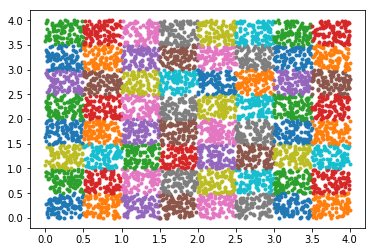

In [6]:
for code in administrativeCodes:
    npoints = 100
    coords = np.array([codes2coord(code) for i in range(npoints)]).reshape(npoints, 2)
    plt.plot(coords[:,0], coords[:,1], ".")

In [7]:
# We define here an household to kind function to label the kind of each household
def components2householdID(components):
    '''agent = [agentID, householdID, tmp_age, tmp_sex, tmp_employ, tmp_edu, tmp_income]'''
    nPeople = len(components)
    nAdults = sum([1 for component in components if component[2] >= 18])
    nChildren = nPeople - nAdults
    if nPeople == 1:
        # Single
        return 0
    elif nPeople == 2 and nAdults == 2:
        # Couple, no children
        return 1
    elif nPeople > 2 and nAdults == 2:
        # Couple children
        return 2
    elif nPeople >= 2 and nAdults == 1:
        # Single parent with children
        return 3
    else:
        raise RuntimeError, "Unkwown combination of %d people, %d adults and %d children...." %\
                            (nPeople, nAdults, nChildren)
    

In [8]:
%%time

agentsTable = []
householdsTable = []
workplacesTable = []

counterPeople = {}

householdID = 0
agentID = 0
workplaceID = 0

for l0 in level0codes:
    for l1 in level1codes:
        for l2 in level2codes:
            tmp_adminCode = (l0, l1, l2)
            counterPeople[tmp_adminCode] =  {"children": 0, "adults": 0, "working": 0,\
                                      "kindergarden": 0, "elementary": 0, "secondary": 0,}
            tmp_agentsTable = []
            
            size2 = 0
            l3 = -1
            while size2 < sizeLevel2:
                l3 += 1
                size3 = 0
                
                l4 = -1
                while size3 < sizeLevel3:
                    l4 += 1
                    size4 = 0
                    while size4 < sizeLevel4:
                        tmp_hhsize = hhsize()
                        
                        tmp_house_kind = []
                        tmp_house_kind.append(1) # 1 adult for sure
                        
                        if tmp_hhsize >= 2:
                            if tmp_hhsize == 2:
                                if np.random.rand() < prob2sizedHouseholdCouple:
                                    tmp_house_kind.append(1)
                                else:
                                    # Lone parent
                                    tmp_house_kind.append(0)
                            else:
                                tmp_house_kind.append(1)
                                tmp_house_kind.extend([0]*(tmp_hhsize-2))
                            
                        tmp_household = []
                        for componentKind in tmp_house_kind:
                            if componentKind == 1:
                                # Adult
                                tmp_age, tmp_sex = ageAdult(), sexAgent()
                                tmp_employ, tmp_edu = adultEmployed(), adultEducation()
                                tmp_income = 0 if not tmp_employ else adultIncome()
                                if tmp_age > 67: tmp_employ = 0 # Retirement
                                
                                counterPeople[tmp_adminCode]["adults"] += 1
                                if tmp_employ:
                                    counterPeople[tmp_adminCode]["working"] += 1
                            elif componentKind == 0:
                                # Child
                                tmp_age, tmp_sex = ageChild(), sexAgent()
                                tmp_edu, tmp_income = 0, 0
                                
                                counterPeople[tmp_adminCode]["children"] += 1
                                if 0<= tmp_age < 6:
                                    counterPeople[tmp_adminCode]["kindergarden"] += 1
                                    tmp_employ = 5
                                elif 6<= tmp_age < 11:
                                    counterPeople[tmp_adminCode]["elementary"] += 1
                                    tmp_employ = 6
                                elif 11<= tmp_age < 19:
                                    counterPeople[tmp_adminCode]["secondary"] += 1
                                    tmp_employ = 7
                                    tmp_edu = 1
                            else:
                                raise RuntimeError, "Unknown component kind %r in household!" % componentKind
                            tmp_agent = [agentID, householdID, tmp_age, tmp_sex, componentKind, tmp_employ, tmp_edu, tmp_income]
                            tmp_agentsTable.append(tmp_agent)
                            agentID += 1
                            
                            tmp_household.append(tmp_agent)
                            
                        tmp_lon, tmp_lat = codes2coord(tmp_adminCode)
                        tmp_hhKind = components2householdID(tmp_household)
                        
                        householdsTable.append((householdID, l0, l1, l2, l3, l4, tmp_hhsize, tmp_hhKind, tmp_lon, tmp_lat))
                        householdID += 1
                        
                        size4 += tmp_hhsize
                        size3 += tmp_hhsize
                        size2 += tmp_hhsize
                          
            # Here we have to create the schools and workplaces...
            # create schools workplaces and then assign the people to them...
            def create_workplace(kind):
                global workplaceID
                global tmp_adminCode
                
                if kind < 5:
                    tmp_size = workplaceSize(kind)
                else:
                    tmp_size = schoolSize(kind)
                tmp_id = workplaceID
                tmp_lon, tmp_lat = codes2coord(tmp_adminCode)
                out = [tmp_id]
                out.extend([c for c in tmp_adminCode])
                out.extend([tmp_size, kind, tmp_lon, tmp_lat])
                workplacesTable.append(out)
                workplaceID += 1
                
                return [tmp_id, tmp_size]
            
            tmp_kindergarden = None
            if counterPeople[tmp_adminCode]["kindergarden"] > 0: tmp_kindergarden = create_workplace(kind=5)
            
            tmp_elementary = None
            if counterPeople[tmp_adminCode]["elementary"] > 0: tmp_elementary = create_workplace(kind=6)
                
            tmp_secondary = None
            if counterPeople[tmp_adminCode]["secondary"] > 0: tmp_secondary = create_workplace(kind=7)

            tmp_workplace = None
            if counterPeople[tmp_adminCode]["working"] > 0: tmp_workplace = create_workplace(kind=1)
                
            for tmp_agent in tmp_agentsTable:
                tmp_employ = tmp_agent[4]
                if tmp_employ == 0:
                    # Unemplyed, negative workplace
                    tmp_agent.append(-1)
                elif tmp_employ == 1:
                    # Employed, put in current workplace and check if a new one is needed.
                    tmp_agent.append(tmp_workplace[0])
                    tmp_workplace[1] -= 1
                    if tmp_workplace[1] == 0: tmp_workplace = create_workplace(kind=tmp_employ)
                elif tmp_employ == 5:
                    # Kinderg, put in current workplace and check if a new one is needed.
                    tmp_agent.append(tmp_kindergarden[0])
                    tmp_kindergarden[1] -= 1
                    if tmp_kindergarden[1] == 0: tmp_kindergarden = create_workplace(kind=tmp_employ)
                elif tmp_employ == 6:
                    # elementary, put in current workplace and check if a new one is needed.
                    tmp_agent.append(tmp_elementary[0])
                    tmp_elementary[1] -= 1
                    if tmp_elementary[1] == 0: tmp_elementary = create_workplace(kind=tmp_employ)
                elif tmp_employ == 7:
                    # Secondary, put in current workplace and check if a new one is needed.
                    tmp_agent.append(tmp_secondary[0])
                    tmp_secondary[1] -= 1
                    if tmp_secondary[1] == 0: tmp_secondary = create_workplace(kind=tmp_employ)
                else:
                    raise RuntimeError("Unknown case in emplyment: %d" % tmp_employ)
            agentsTable.extend(tmp_agentsTable)

CPU times: user 453 ms, sys: 4.43 ms, total: 457 ms
Wall time: 457 ms


In [9]:
len(agentsTable), len(householdsTable), len(workplacesTable)

(22012, 8218, 538)

In [10]:
agentsDF = pd.DataFrame(agentsTable, columns=["id", "hh", "age", "sex", "role", "empl", "edu", "income", "wp"])
#agentsDF.set_index("id", drop=True, inplace=True)
agentsDF.head(10)

id  hh  age  sex  role  empl  edu       income  wp
0   0   0   62    1     1     1    2  1256.404135   3
1   1   0   97    0     1     0    1  1098.935337   3
2   2   0    3    0     0     5    0     0.000000  -1
3   3   0   15    0     0     7    1     0.000000  -1
4   4   0   17    1     0     7    1     0.000000  -1
5   5   1   68    0     1     0    1  1433.655105   3
6   6   2   37    0     1     1    1  1255.974944   3
7   7   3   36    0     1     1    1  1064.537179   3
8   8   3    7    0     0     6    0     0.000000  -1
9   9   4   40    0     1     1    1  1232.602755   3

In [11]:
householdsDF = pd.DataFrame(householdsTable, columns=["id", "l0", "l1", "l2", "l3", "l4", "size", "kind", "lon", "lat"])
#householdsDF.set_index("id", drop=True, inplace=True)
householdsDF.head()

id  l0  l1  l2  l3  l4  size  kind       lon       lat
0   0   0   0   0   0   0     5     2  0.227056  0.318913
1   1   0   0   0   0   0     1     0  0.414940  0.210292
2   2   0   0   0   0   0     1     0  0.380359  0.459472
3   3   0   0   0   0   0     2     3  0.454393  0.296077
4   4   0   0   0   0   0     3     2  0.366287  0.486031

In [12]:
workplacesDF = pd.DataFrame(workplacesTable, columns=["id", "l0", "l1", "l2", "size", "kind", "lon", "lat"])
#workplacesDF.set_index("id", drop=True, inplace=True)
workplacesDF.head()

id  l0  l1  l2  size  kind       lon       lat
0   0   0   0   0    32     5  0.431818  0.447053
1   1   0   0   0    39     6  0.472801  0.235523
2   2   0   0   0    65     7  0.462352  0.175953
3   3   0   0   0    46     1  0.193615  0.213841
4   4   0   0   0    32     1  0.068021  0.032573

### Add fake leve 4 and 5 to workplaces
This should be done before and in a general way...

In [13]:
workplacesDF.insert(np.argmax(workplacesDF.columns.get_values() == "size"), "l3", np.random.randint(householdsDF.l3.max()+1, size=workplacesDF.shape[0]))

In [14]:
workplacesDF.insert(np.argmax(workplacesDF.columns.get_values() == "size"), "l4", np.random.randint(householdsDF.l4.max()+1, size=workplacesDF.shape[0]))

In [15]:
workplacesDF.head()

id  l0  l1  l2  l3  l4  size  kind       lon       lat
0   0   0   0   0   3   3    32     5  0.431818  0.447053
1   1   0   0   0   3   0    39     6  0.472801  0.235523
2   2   0   0   0   2   0    65     7  0.462352  0.175953
3   3   0   0   0   3   2    46     1  0.193615  0.213841
4   4   0   0   0   2   2    32     1  0.068021  0.032573

In [16]:
print counterPeople[(0,0,0)], counterPeople[(0,0,0)]["adults"] + counterPeople[(0,0,0)]["children"]

{'kindergarden': 43, 'adults': 206, 'working': 96, 'elementary': 36, 'children': 135, 'secondary': 56} 341


## Adding some fake commuting for workers / students

We start from a random origin-destination matrix $M$ whose entry $m_{i,j}$
sets the fraction of workers going from code $i$ to $j$ (so that the matrix
is not symmetric, in general). We define $M_W$ to be the origin destination
matrix for workplaces and $M_S$ to be the schools one.

In [17]:
numberOfAdminCodes = len(administrativeCodes)

def makeCommutingMatrix(ndim, toOriginVolume=.9):
    '''
    Function that returns a matrix with toOriginVolume in the
    diagonal and random values summing to 1-toOriginVolume in the
    out-of-diagonal place in a row so that sum_k m_{j,k} = 1.0
    '''
    tmp_mat = np.random.rand(ndim, ndim)
    np.fill_diagonal(tmp_mat, .0)
    tmp_mat = np.divide(tmp_mat, tmp_mat.sum(axis=1, keepdims=True)/(1. - toOriginVolume))
    np.fill_diagonal(tmp_mat, toOriginVolume)
    return tmp_mat

# We let the up to the 10% of people to commute for work and 5% for school
# Leave the rest to go inside the same administrative level
M_S = makeCommutingMatrix(numberOfAdminCodes, toOriginVolume=.9)
M_W = makeCommutingMatrix(numberOfAdminCodes, toOriginVolume=.95)

### Move workers/students

Here we apply a naive approach:
- for each source and for each worker we draw its destination. If it is in the same admin code we leave the worker in the assigned workspace otherwise we subtract it from the current workplace and add it to a random workplace in the origin admin code.
- at the end of the process we update the nuber of people working in each workplace;

In [18]:
agentsDF.head(1)

id  hh  age  sex  role  empl  edu       income  wp
0   0   0   62    1     1     1    2  1256.404135   3

In [19]:
householdsDF.head(1)

id  l0  l1  l2  l3  l4  size  kind       lon       lat
0   0   0   0   0   0   0     5     2  0.227056  0.318913

In [20]:
workplacesDF.head(1)

id  l0  l1  l2  l3  l4  size  kind       lon       lat
0   0   0   0   0   3   3    32     5  0.431818  0.447053

In [21]:
%%time

for agentIndex, agent in agentsDF.iterrows():
    if agent.empl > 0:
        # Either worker or student
        # Extract the index of the administrative code
        tmp_codes = householdsDF[householdsDF.id == agent.hh].iloc[0][["l0", "l1", "l2"]]
        tmp_codes = tuple(tmp_codes.values.astype(int))
        origin_index = administrativeCodes.index(tmp_codes)
        
        if 0 < agent.empl < 5:
            # Worker
            ref_row = M_W[origin_index,:]
        elif 5 <= agent.empl < 10:
            # School
            ref_row = M_S[origin_index,:]
        
        destin_index = np.argmin(np.random.rand() > ref_row.cumsum())

        if destin_index != origin_index:
            # Select another workplace in the destination
            # If no workplace of this kind in this destination
            # select another destination
            # Subtract one to leaving workplace
            dest_codes = administrativeCodes[destin_index]
            maxTrials = 10
            while True:
                dest_wp = workplacesDF[\
                                       (workplacesDF["l0"] == dest_codes[0]) &\
                                       (workplacesDF["l1"] == dest_codes[1]) &\
                                       (workplacesDF["l2"] == dest_codes[2]) &\
                                       (workplacesDF["kind"] == agent.empl)\
                                      ]
                if len(dest_wp) > 0:
                    dest_wp = dest_wp.iloc[np.random.randint(len(dest_wp))]
                    #print "Moving", agent, "to", dest_wp
                    agentsDF.at[agentIndex, "wp"] = int(dest_wp.id)
                    break
                    
                maxTrials -= 1
                if maxTrials == 0:
                    break       
                else:
                    destin_index = origin_index
                    while destin_index == origin_index:
                        destin_index = np.argmin(np.random.rand() > ref_row.cumsum())
    sys.stdout.write("\r%06d / %06d ...   " % (agentIndex+1, agentsDF.shape[0]))
    sys.stdout.flush()

022012 / 022012 ...   CPU times: user 39.8 s, sys: 6.3 s, total: 46.1 s
Wall time: 40.2 s


In [22]:
agentsDF[agentsDF.id == 14]

id  hh  age  sex  role  empl  edu  income  wp
14  14   6   13    0     0     7    1     0.0  -1

In [23]:
householdsDF[householdsDF.id == 10.]

id  l0  l1  l2  l3  l4  size  kind       lon       lat
10  10   0   0   0   0   1     1     0  0.031069  0.326858

In [24]:
workplacesDF[workplacesDF.id == 258]

id  l0  l1  l2  l3  l4  size  kind      lon       lat
258  258   1   3   2   0   3    56     1  3.01403  1.985513

### Recompute right number of workers per workplace

We use the pandas value counts to see how many people work in each workplace.

In [25]:
for i, c in agentsDF.wp.value_counts().iteritems():
    if i >= 0:
        wp_index = workplacesDF.loc[workplacesDF.id == i]
        workplacesDF.at[wp_index.index, "size"] = int(c)

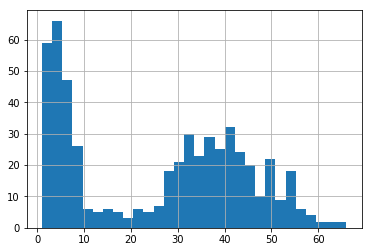

In [26]:
workplacesDF["size"].hist(bins=30)

## Demography

We retrieve from the demography tables of the Eurostat the statistics for a number of areas equal to the number of leaves at the third level of the hierarchy.

We limit ourselves to the years since 2000 because of lack of data in the previous years.

In [113]:
natality_df = pd.read_pickle("../../../../maps_and_rasters/resources/Europe/population/demography/birthRates_1990-2015_age_nuts2_PANDAS.pkl")
mortality_df = pd.read_pickle("../../../../maps_and_rasters/resources/Europe/population/demography/deathRates_1990-2015_sexAge_nuts2_PANDAS.pkl")

In [114]:
natality_df.head()

1990                                     ... 2015                      \
sex     0                                     ...    1                       
age   1   2   3   4   5   6   7   8   9   10  ...  91  92  93  94  95  96    
nuts                                          ...                            
AL      0   0   0   0   0   0   0   0   0   0 ...    0   0   0   0   0   0   
AL0     0   0   0   0   0   0   0   0   0   0 ...    0   0   0   0   0   0   
AT      0   0   0   0   0   0   0   0   0   0 ...    0   0   0   0   0   0   
AT1     0   0   0   0   0   0   0   0   0   0 ...    0   0   0   0   0   0   
AT11    0   0   0   0   0   0   0   0   0   0 ...    0   0   0   0   0   0   

                      
sex                   
age  97  98  99  100  
nuts                  
AL     0   0   0   0  
AL0    0   0   0   0  
AT     0   0   0   0  
AT1    0   0   0   0  
AT11   0   0   0   0  

[5 rows x 5200 columns]

In [115]:
mortality_df.head()

1990                                                                \
sex        -1                                                                 
age       1        2        3        4        5        6       7        8     
nuts                                                                          
AL    0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.0000  0.00000   
AL0   0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.0000  0.00000   
AT    0.00063  0.00040  0.00039  0.00031  0.00025  0.00018  0.0002  0.00013   
AT1   0.00061  0.00035  0.00035  0.00041  0.00015  0.00012  0.0002  0.00011   
AT11  0.00071  0.00000  0.00035  0.00033  0.00000  0.00000  0.0000  0.00000   

                       ... 2015                                      
sex                    ...    1                                      
age       9        10  ...  91  92  93  94  95  96  97  98  99  100  
nuts                   ...                                           
AL    0.00000  0.00000 ...    1   1   1   1   1   1   1   1   1   1  
AL0   0.00000  0.00000 ...    1   1   1   1   1   1   1   1   1   1  
AT    0.00010  0.00015 ...    1   1   1   1   1   1   1   1   1   1  
AT1   0.00009  0.00018 ...    1   1   1   1   1   1   1   1   1   1  
AT11  0.00000  0.00000 ...    1   1   1   1   1   1   1   1   1   1  

[5 rows x 7800 columns]

In [116]:
# Check that the mortality and natality tables have the same nuts
assert len(natality_df.index.symmetric_difference(mortality_df.index)) == 0

In [117]:
natality_df.columns.get_level_values(0).symmetric_difference(mortality_df.columns.get_level_values(0))

Int64Index([], dtype='int64')

### Select the correspondence between nuts and geocodes

Now compute the number of codes we need and then select the nuts for those codes and insert the data.
We select them from the nuts level 1 so the codes with string length == 3. We restrict our search to Italy, France, Germany, and Belgium sice they have the most complete data.

In [165]:
from random import sample

In [171]:
# Now compute the number of codes we need and then select the nuts for those codes and insert the data
# We select them from the nuts level 2 so the codes with string length == 4
demographyLevel = 3
dateFormat = "%Y%m%d"

filterNuts = ["IT", "DE", "FR", "BE", "SP", "NL", "GR"]

row2geocode = lambda r: tuple([r["l%d"%l] for l in range(demographyLevel)])
codesForDemography = set([row2geocode(r) for _, r in householdsDF.iterrows()])
numberOfCodesForDemography = len(codesForDemography)
nutsSelected = sample([c for c in natality_df.index if len(c) == 4 and c[:2] in filterNuts], numberOfCodesForDemography)

# The map between the table nuts to the output geocode
nuts2geocode = {nuts: geocode for nuts, geocode in zip(nutsSelected, codesForDemography)}

In [172]:
%%time
outData = []
for tmp_nuts in nutsSelected:
    tmp_geocode = nuts2geocode[tmp_nuts]
    for year in natality_df.columns.get_level_values(0).unique():
        if year < 2002: continue
        for sex in [0, 1]:
            for age in range(1, 101):
                tmp_row = [int(i) for i in tmp_geocode] + [datetime.datetime(year, 1, 1).strftime(dateFormat), sex, age]
                tmp_column = tuple([year, sex, age])
                outData.append(tmp_row + [natality_df[tmp_column][tmp_nuts], mortality_df[tmp_column][tmp_nuts]])

CPU times: user 11.1 s, sys: 23.2 ms, total: 11.1 s
Wall time: 11.4 s


In [173]:
demographyDF = pd.DataFrame(outData, columns=["l%d"%d for d in range(demographyLevel)] + ["date", "sex", "age", "natality", "mortality"])
demographyDF.head()

l0  l1  l2      date  sex  age  natality  mortality
0   3   0   2  20020101    0    1       0.0    0.00120
1   3   0   2  20020101    0    2       0.0    0.00047
2   3   0   2  20020101    0    3       0.0    0.00000
3   3   0   2  20020101    0    4       0.0    0.00025
4   3   0   2  20020101    0    5       0.0    0.00050

### Create fake dates

To test the I/O demography functions we rewrite all the original dates to to be in the 2015 years because we will run the example tests of the program in the first half of 2015.

In [174]:
currentDates = demographyDF.date.unique()
numberOfDates = len(currentDates)
timeDeltaPerDate = datetime.timedelta(days=int(np.ceil(200./numberOfDates)))
dateZero = datetime.datetime(2014,12,31,0,0,0)
old2newDates = {oldDate: (dateZero+timeDeltaPerDate*iii).strftime(dateFormat) for iii, oldDate in enumerate(currentDates)}

In [175]:
demographyDF.replace(to_replace={"date": old2newDates}, inplace=True)
demographyDF.head()

l0  l1  l2      date  sex  age  natality  mortality
0   3   0   2  20141231    0    1       0.0    0.00120
1   3   0   2  20141231    0    2       0.0    0.00047
2   3   0   2  20141231    0    3       0.0    0.00000
3   3   0   2  20141231    0    4       0.0    0.00025
4   3   0   2  20141231    0    5       0.0    0.00050

In [176]:
demographyDF.date.unique()

array(['20141231', '20150115', '20150130', '20150214', '20150301',
       '20150316', '20150331', '20150415', '20150430', '20150515',
       '20150530', '20150614', '20150629', '20150714'], dtype=object)

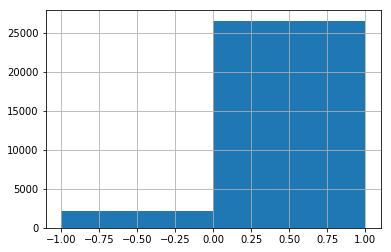

In [177]:
# Check that we do not have too many zeroes...
demographyDF[demographyDF.age >= 85].mortality.hist(bins=[-1, 0.0000000000001, 1.])

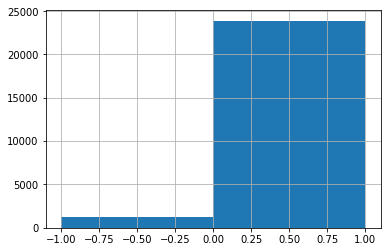

In [178]:
demographyDF[(demographyDF.age.between(18, 45)) & (demographyDF.sex == 1)].natality.hist(bins=[-1, 0.000000001, 1.])

## Saving to hdf5 file

In [179]:
fout = h5py.File("../data/synthPop_5levels_prova_small.h5", mode="w")
fout.clear()

### Agents

In [180]:
# Agents table

typeNames =   ["id",  "hh",  "age", "sex", "role", "employed", "edu", "income", "wp"]
typeFormats = ["<i8", "<i8", "<i8", "<i8", "<i8",  "<i8",      "<i8", "<f8",    "<i8"]
itemsize = len(typeFormats)*8
typeOffset = range(0, itemsize, 8)
agentType = np.dtype({"names": typeNames, "formats": typeFormats, }) 

dataAsMatrix = agentsDF.as_matrix()
dataAsMatrix = np.array([tuple(row) for row in dataAsMatrix], dtype=agentType)

fout.create_dataset(name="agent", dtype=agentType, data=dataAsMatrix)

<HDF5 dataset "agent": shape (22012,), type "|V72">

In [181]:
# Check correspondence
agentsDF.head()

id  hh  age  sex  role  empl  edu       income  wp
0   0   0   62    1     1     1    2  1256.404135   3
1   1   0   97    0     1     0    1  1098.935337   3
2   2   0    3    0     0     5    0     0.000000  -1
3   3   0   15    0     0     7    1     0.000000  -1
4   4   0   17    1     0     7    1     0.000000  -1

In [182]:
fout["agent"][0]

(0, 0, 62, 1, 1, 1, 2, 1256.40413454, 3)

### Households

In [183]:
# Household table

typeNames =   ["id",  "l0",  "l1",  "l2",  "l3",  "l4",  "size", "kind", "lon", "lat"]
typeFormats = ["<i8", "<i8", "<i8", "<i8", "<i8", "<i8", "<i8",  "<i8",  "<f8", "<f8"]

householdType = np.dtype({"names": typeNames, "formats": typeFormats, }) 

dataAsMatrix = householdsDF.as_matrix()
dataAsMatrix = np.array([tuple(row) for row in dataAsMatrix], dtype=householdType)

fout.create_dataset(name="household", dtype=householdType, data=dataAsMatrix)

<HDF5 dataset "household": shape (8218,), type "|V80">

In [184]:
# Check correspondence
householdsDF.head()

id  l0  l1  l2  l3  l4  size  kind       lon       lat
0   0   0   0   0   0   0     5     2  0.227056  0.318913
1   1   0   0   0   0   0     1     0  0.414940  0.210292
2   2   0   0   0   0   0     1     0  0.380359  0.459472
3   3   0   0   0   0   0     2     3  0.454393  0.296077
4   4   0   0   0   0   0     3     2  0.366287  0.486031

In [185]:
fout["household"][0]

(0, 0, 0, 0, 0, 0, 5, 2, 0.22705605, 0.31891263)

### Workplaces/school

In [186]:
# Workplaces table

typeNames =   ["id",  "l0",  "l1",  "l2",  "l3",  "l4",  "size", "kind", "lon", "lat"]
typeFormats = ["<i8", "<i8", "<i8", "<i8", "<i8", "<i8", "<i8",  "<i8",  "<f8", "<f8"]

workplaceType = np.dtype({"names": typeNames, "formats": typeFormats,}) 

dataAsMatrix = workplacesDF.as_matrix()
dataAsMatrix = np.array([tuple(row) for row in dataAsMatrix], dtype=workplaceType)

fout.create_dataset(name="workplace", dtype=workplaceType, data=dataAsMatrix)

<HDF5 dataset "workplace": shape (538,), type "|V80">

In [187]:
# Check correspondence
workplacesDF.head()

id  l0  l1  l2  l3  l4  size  kind       lon       lat
0   0   0   0   0   3   3    12     5  0.431818  0.447053
1   1   0   0   0   3   0     4     6  0.472801  0.235523
2   2   0   0   0   2   0    15     7  0.462352  0.175953
3   3   0   0   0   3   2    48     1  0.193615  0.213841
4   4   0   0   0   2   2    34     1  0.068021  0.032573

In [188]:
fout["workplace"][0]

(0, 0, 0, 0, 3, 3, 12, 5, 0.43181788, 0.44705285)

### Define the types

In [189]:
type_group = fout.create_group("types")

In [190]:
type_group["agent"] = agentType
type_group["household"] = householdType
type_group["workplace"] = workplaceType

### Demography

In [191]:
# Demography table

typeNames =   ["l%d" % d for d in range(demographyLevel)] + ["date", "sex", "age", "natality", "mortality"]
typeFormats = ["<i8"]*demographyLevel + ["S8", "<i8",  "<i8",  "<f8", "<f8"]

demographyType = np.dtype({"names": typeNames, "formats": typeFormats,}) 

dataAsMatrix = demographyDF.as_matrix()
dataAsMatrix = np.array([tuple(row) for row in dataAsMatrix], dtype=demographyType)

fout.create_dataset(name="demography", dtype=demographyType, data=dataAsMatrix)

<HDF5 dataset "demography": shape (179200,), type "|V64">

In [192]:
# Check correspondence
demographyDF.head()

l0  l1  l2      date  sex  age  natality  mortality
0   3   0   2  20141231    0    1       0.0    0.00120
1   3   0   2  20141231    0    2       0.0    0.00047
2   3   0   2  20141231    0    3       0.0    0.00000
3   3   0   2  20141231    0    4       0.0    0.00025
4   3   0   2  20141231    0    5       0.0    0.00050

In [193]:
fout["demography"][0]

(3, 0, 2, '20141231', 0, 1, 0., 0.0012)

### Close the file

In [194]:
fout.close()

## Benchmark reading methods

In [3]:
testFile = "../data/synthPop_5levels_prova_small.h5"
dataset = "agent"

In [4]:
fileHandle = h5py.File(testFile, mode="r")
table = fileHandle[dataset]

In [46]:
dataset in fileHandle

True

### Read row by row

In [10]:
type(table)

h5py._hl.dataset.Dataset

In [17]:
%%time
for row in table:
    pass
print "\nDone"


Done
CPU times: user 2.65 s, sys: 26.5 ms, total: 2.68 s
Wall time: 2.64 s


In [7]:
row

(22022, 8088, 17, 0, 7, 1,  0., 468)

### Load to array

In [18]:
%%time
tableArr = np.empty(shape=table.shape, dtype=table.dtype)
table.read_direct(tableArr)

for row in tableArr:
    #sys.stdout.write("\r%r" % row)
    #sys.stdout.flush()
    pass
print "\nDone"


Done
CPU times: user 4.99 ms, sys: 0 ns, total: 4.99 ms
Wall time: 3.61 ms


In [20]:
table.dtype

dtype([('id', '<i8'), ('hh', '<i8'), ('age', '<i8'), ('sex', '<i8'), ('employed', '<i8'), ('edu', '<i8'), ('income', '<f8'), ('wp', '<i8')])

In [19]:
table.dtype.names

('id', 'hh', 'age', 'sex', 'employed', 'edu', 'income', 'wp')

In [21]:
S = 0
I = 1
A = 2
R = 4
V = 8

In [31]:
np.unique(np.random.randint(10, size=10))

array([0, 1, 2, 3, 5, 7, 8])

In [29]:
np.where(np.random.rand(100) < .1)[0]

array([17, 29, 30, 36, 49, 69, 73, 74, 81, 85])

In [44]:
np.random.choice(a, 2, replace=False)

array([4, 6])

In [41]:
a[np.random.rand(len(a)) < .3]

array([2, 3, 6, 7])

In [26]:
R | I

5

In [34]:
s = set([1,2,3,4,5,6,7])
a = np.array(list(s))

In [35]:
a

array([1, 2, 3, 4, 5, 6, 7])

In [1]:
import numpy as np

In [2]:
typeNames =   ["id",  "l0",  "l1",  "l2",  "l3",  "l4",  "size", "kind", "lon", "lat"]
typeFormats = ["<i8", "<i8", "<i8", "<i8", "<i8", "<i8", "<i8",  "<i8",  "<f8", "<f8"]

householdType = np.dtype({"names": typeNames, "formats": typeFormats, }) 

In [20]:
e = np.array([(1,1,1,1,1,1,1,1,1,1), (1,1,1,1,1,1,1,1,1,1), (1,1,1,1,1,1,1,1,1,1)], dtype=householdType)

In [21]:
e

array([(1, 1, 1, 1, 1, 1, 1, 1,  1.,  1.),
       (1, 1, 1, 1, 1, 1, 1, 1,  1.,  1.),
       (1, 1, 1, 1, 1, 1, 1, 1,  1.,  1.)],
      dtype=[('id', '<i8'), ('l0', '<i8'), ('l1', '<i8'), ('l2', '<i8'), ('l3', '<i8'), ('l4', '<i8'), ('size', '<i8'), ('kind', '<i8'), ('lon', '<f8'), ('lat', '<f8')])

In [26]:
e

array([(1, 1, 1, 1, 1, 1, 1, 1,  1.,  1.),
       (1, 1, 1, 1, 1, 1, 1, 1,  1.,  1.),
       (1, 1, 1, 1, 1, 1, 1, 1,  1.,  1.)],
      dtype=[('id', '<i8'), ('l0', '<i8'), ('l1', '<i8'), ('l2', '<i8'), ('l3', '<i8'), ('l4', '<i8'), ('size', '<i8'), ('kind', '<i8'), ('lon', '<f8'), ('lat', '<f8')])

In [27]:
import h5py

In [28]:
f = h5py.File("../data/synthPop_5levels_prova.h5", )

In [32]:
at = f["types"]["agent"]

In [43]:
at

<HDF5 named type "agent" (dtype |V64)>

In [44]:
at.dtype.names

('id', 'hh', 'age', 'sex', 'employed', 'edu', 'income', 'wp')

In [49]:
at.dtype[0] 

True

In [39]:
at.dtype.names.index("age")

2

In [40]:
ag = f["agent"]

In [42]:
ag[0][at.dtype.names.index("age")]

83

In [50]:
f.close()